In [1]:
# Collected job data from Lisa using the following command:
# sacct -a --starttime 2020-01-01 --format=jobid,gid,uid,partition,submit,start,end,elapsedraw,cputimeraw,ncpus,nnodes,nodelist,exitcode,state,timelimit > $HOME/jobdata.csv

# Required packages for processing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, datetime, pytz
from matplotlib.ticker import MultipleLocator, FixedLocator, LogLocator, NullFormatter
from datetime import date, datetime, time
from multiprocessing import cpu_count
from pandarallel import pandarallel
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

%matplotlib inline

In [2]:
# Required preprocessing/parsing of the job data
def preprocess_jobdata_to_df(name):
    with open(os.path.join(location_job_data_csv, name),'r') as file:
        filedata = file.read()
        filedata = filedata.replace('None assigned','NoneAssigned')
    with open(os.path.join(location_job_data_csv, str('processed_'+name)),'w') as file:
        file.write(filedata)
    jobdata = pd.read_fwf(os.path.join(location_job_data_csv, str('processed_'+name)), delimiter=r"\s+", header=None)#, low_memory=False)
    jobdata = jobdata.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    jobdata = jobdata.rename(columns=jobdata.iloc[0]).drop(jobdata.index[0])
    jobdata = jobdata.iloc[1:]
    jobdata = jobdata.astype({"ElapsedRaw": int, "CPUTimeRAW": int, "NCPUS": int})
    return(jobdata)


In [ ]:
# Import job data
location_job_data_csv = "/path/to/surfsara-jobdata/"
jobdata = preprocess_jobdata_to_df('jobdata.csv')

In [ ]:
# Some extra preprocessing required for the job data, e.g. filtering out irrelevant login nodes
filtered_jobs = jobdata[(jobdata["Start"] >= '2019-12-29 23:00:00') & (jobdata["Start"] <= '2020-08-07 21:59:45')]
filtered_jobs = filtered_jobs[(~filtered_jobs["NodeList"].str.contains("None")) & (~filtered_jobs["NodeList"].str.contains("software")) & (~filtered_jobs["NodeList"].str.contains("login"))]
filtered_jobs["ElapsedRaw"] = filtered_jobs["ElapsedRaw"].apply(lambda x: (x / 60) / 60)

In [5]:
# Creates a column that indicates if a job was executed on ML nodes 
gpu_nodes = {
    "r28n1", "r28n2", "r28n3", "r28n4", "r28n5",
    "r29n1", "r29n2", "r29n3", "r29n4", "r29n5",
    "r30n1", "r30n2", "r30n3", "r30n4", "r30n5", "r30n6", "r30n7",
    "r31n1", "r31n2", "r31n3", "r31n4", "r31n5", "r31n6"
    "r32n1", "r32n2", "r32n3", "r32n4", "r32n5", "r32n6", "r32n7",
    "r33n2", "r33n3", "r33n5", "r33n6",
    "r34n1", "r34n2", "r34n3", "r34n4", "r34n5", "r34n6", "r34n7",
    "r35n1", "r35n2", "r35n3", "r35n4", "r35n5",
    "r36n1", "r36n2", "r36n3", "r36n4", "r36n5",
    "r38n1", "r38n2", "r38n3", "r38n4", "r38n5",
}

def split_nodes(s): # parses node strings like r12n[1-30,32] to r12n1, r12n2 ... r12n30, r12n32
    if s is None or len(s) == 0:
        return set()
    
    s = s.replace("\r\n", "").replace("\n", "").replace("\t", "")

    start = 0
    index = 0
    rack_chunks = []
    in_bracket = False
    while index < len(s):  # Separate them in parts like r12n[1-30,32] or r13n1
        if s[index] == "[":
            in_bracket = True
        elif s[index] == "]":
            in_bracket = False
        elif s[index] == "," and not in_bracket:
            rack_chunks.append(s[start: index])
            start = index + 1
        index += 1
    rack_chunks.append(s[start: index])  # Add the last line
    
    node_names = set()

    for rack_chunk in rack_chunks:
        if "[" in rack_chunk:
            prefix, postfix = rack_chunk.split("[")
            postfix = postfix[:-1]  # Remove the last bracket
            nodes = postfix.split(",")
            for node in nodes:
                if "-" in node:
                    start, end = node.split("-")
                    if not start.isnumeric() or not end.isnumeric():
                        continue
                    for i in range(int(start), int(end) + 1):
                        node_names.add("{}{}".format(prefix, i))
                else:
                    node_names.add("{}{}".format(prefix, node))
        else:
            node_names.add(rack_chunk)

    return node_names

def calculate_perjob(row):
    nodes = row["NodeList"]
    splitnodes = split_nodes(nodes)
    return any([n in gpu_nodes for n in splitnodes])

pandarallel.initialize(nb_workers=min(cpu_count(), 8), progress_bar=True)
filtered_jobs["is_gpu"] =  filtered_jobs.parallel_apply(calculate_perjob, axis=1)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [72]:
def normalize(df):
    df = df.value_counts(sort=False, normalize=True).rename_axis('target').reset_index(name='pdf')
    df["cdf"] = df["pdf"].cumsum()
    return df

completed_elapsed_values = filtered_jobs[filtered_jobs['State'] == "COMPLETED"]
all_values_df = pd.DataFrame({"target": completed_elapsed_values["ElapsedRaw"].values * 3600})
count_df = normalize(all_values_df)

# Print how many jobs are <= duration in seconds
duration = 300
print(count_df[count_df['target'].le(duration) | np.isclose(count_df['target'], duration, rtol=1e-10, atol=1e-12)].tail(1)['cdf'].iloc[0])
    
# Generate array containing counts of job lenght 
counts = np.unique(completed_elapsed_values["ElapsedRaw"].values, return_counts=True)
pdf = counts[1] / np.sum(counts[1])
cdf = np.cumsum(pdf)

0.8890666123308374


In [ ]:
# Visualize results
fig = plt.figure()
plt.yscale("log")
plt.locator_params(axis='y', numticks=12)
plt.bar(counts[0], counts[1], width=1)
plt.xlabel("Job duration (hours)")
plt.ylabel("Jobs")
plt.tight_layout()
fig.savefig("job_duration_count.pdf")

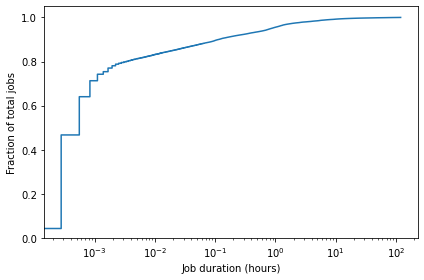

In [14]:
# Generate PDF/CDF
pdf = counts[1] / np.sum(counts[1])
cdf = np.cumsum(pdf)
fig = plt.figure()

plt.ylim(0,1.05)
plt.plot(counts[0], cdf, drawstyle='steps')
plt.xscale("log")
plt.xlabel("Job duration (hours)")
plt.ylabel("Fraction of total jobs")
plt.tight_layout()
fig.savefig("job_duration_cdf.pdf")

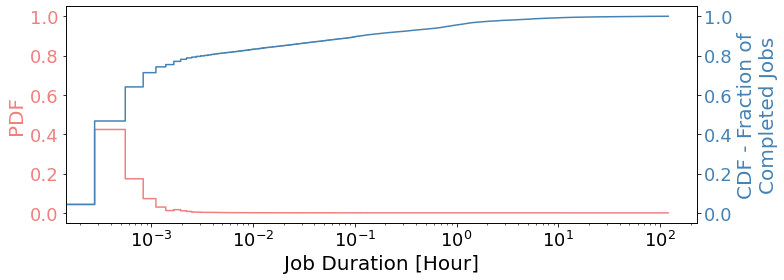

In [74]:
fig, ax1 = plt.subplots(figsize=(11,4))

ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)

ax1.set_xlabel('Job Duration [Hour]', fontsize=20)
ax1.set_ylabel('PDF', color='lightcoral', fontsize=20)
plt.ylim(-0.05,1.05)
plt.xscale("log")
ax1.plot(counts[0], pdf, color='lightcoral', drawstyle='steps')
ax1.tick_params(axis='y', labelcolor='lightcoral')

ax2 = ax1.twinx()

ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='minor', labelsize=18)

color = 'steelblue'
ax2.set_ylabel('CDF - Fraction of\nCompleted Jobs', color=color, fontsize=20)
ax2.plot(counts[0], cdf, color=color, drawstyle='steps')
ax2.tick_params(axis='y', labelcolor=color)
plt.ylim(-0.05,1.05)

fig.tight_layout()
plt.show()
date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"job_duration_cdf_pdf_{date_time}.pdf")

In [ ]:
# Generate array containing counts of cpu core allocation for jobs 
counts_cpus = np.unique(filtered_jobs["NCPUS"].values, return_counts=True)

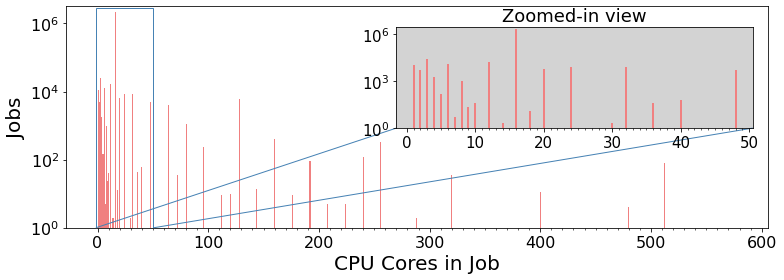

In [13]:
# Visualize results
fig, ax = plt.subplots(figsize=(11,4))

ax.set_yscale("log")
ax.set_ylim(bottom=1)
ax.set_ylim(top=10**6.5)
ax.bar(counts_cpus[0], counts_cpus[1], width=1, color="lightcoral")
ax.set_xlabel("CPU Cores in Job", fontsize=20)

majors = [0, 100, 200, 300, 400, 500, 600]
ax.xaxis.set_major_locator(FixedLocator(majors))
ax.xaxis.set_minor_locator(FixedLocator((np.arange(min(counts_cpus[0]-1), 600, 10))))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

plt.ylabel("Jobs", fontsize=20)
plt.tight_layout()

a = plt.axes([.505, .54, .45, .35], facecolor='lightgrey')
a.set_ylim(bottom=1, top=10**6.45)
a.bar(counts_cpus[0][0:23], counts_cpus[1][0:23], width=0.3, color="lightcoral")
a.set_title('Zoomed-in view', fontsize=18)
a.set_yscale("log")
majors_2 = [0, 10, 20, 30, 40, 50]
a.xaxis.set_major_locator(FixedLocator(majors_2))
a.xaxis.set_minor_locator(FixedLocator((np.arange(min(counts_cpus[0]-1), 50, 1))))
a.tick_params(axis='both', which='major', labelsize=15)
a.tick_params(axis='both', which='minor', labelsize=15)

mark_inset(ax, a, loc1=3, loc2=4, fc="none", ec="steelblue")


date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"job_cpus_count_zoom_{date_time}.pdf")

In [ ]:
# Plot PDF/CDF
pdf = counts_cpus[1] / np.sum(counts_cpus[1])
cdf = np.cumsum(pdf)
fig = plt.figure()
plt.ylim(0,1.05)
plt.plot(counts_cpus[0], cdf, drawstyle='steps')
plt.xscale("symlog")
plt.xlabel("CPU cores in job")
plt.ylabel("Fraction of total jobs")
plt.tight_layout()
fig.savefig("job_cpus_cdf.pdf")

In [ ]:
# Note there seems to be some issue with the plotting library, which does not seem to show every first 
# minor tick after a major tick on log/symlog scales, even when this is hard-coded like below
fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of cores in job')
ax1.set_ylabel('PDF')
plt.ylim(-0.05,1.05)
plt.xscale("symlog", subsx = [1,2,3,4,5,6,7,8,9])
ax1.plot(counts_cpus[0], pdf, color='black', drawstyle='steps')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('CDF - Fraction of total jobs', color=color)
ax2.plot(counts_cpus[0], cdf, color=color, drawstyle='steps')
ax2.tick_params(axis='y', labelcolor=color)
plt.ylim(-0.05,1.05)

fig.tight_layout()
plt.show()
fig.savefig("job_cpus_cdf_pdf.pdf")

In [ ]:
group_date = jobdata[(jobdata["Start"] >= '2019-12-29 23:00:00') & (jobdata["Start"] <= '2020-08-07 21:59:45')]
group_date = group_date[(~group_date["NodeList"].str.contains("None")) & (~group_date["NodeList"].str.contains("software")) & (~group_date["NodeList"].str.contains("login"))]
group_date["squashed_area"] = group_date["ElapsedRaw"] * group_date["NCPUS"]
group_date["Submit"] = pd.to_datetime(group_date["Submit"], utc=True)
group_date = group_date.set_index("Submit")
daily_squashed_area = group_date['squashed_area'].resample('D').sum()

fig = plt.figure()
plt.yscale("log")
plt.ylim(bottom=1)
plt.ylim(top=10**9.5)
plt.locator_params(axis='y', numticks=12)
plt.bar(datelist, daily_squashed_area, width=1)
plt.xlabel("Date")
plt.ylabel("CPU-Hours")
plt.tight_layout()
fig.savefig("job_squashed_area.pdf")

In [ ]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
ax.bar(datelist, daily_squashed_area, width=1)
ax2.bar(datelist, daily_squashed_area, width=1)

ax.set_yscale("log")
ax2.set_yscale("log")

# zoom-in / limit the view to different portions of the data
ax.set_ylim(10**7,10**9.25)
ax2.set_ylim(10**0, 10**3)

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.xlabel("Date")
plt.ylabel("CPU-Hours")
plt.tight_layout()
f.savefig("job_squashed_area_split.pdf")

In [6]:
# Generate list of dates in dataset, again excluding any login nodes from the data
group_date = filtered_jobs.copy()
group_date["Submit"] = pd.to_datetime(group_date["Submit"], utc=True)
group_date = group_date.set_index("Submit")
group_date = group_date.groupby([group_date.index.date, "is_gpu"]).count().unstack(1)
datelist = list(group_date.index.values) 
submissionlist = group_date["JobID"].fillna(0)  # just grab one column as all columns have the same counts
submissionlist.columns = ['generic', 'ml']

In [43]:
date_max_value = submissionlist.sum(axis=1).idxmax()
max_val = submissionlist.loc[date_max_value].sum()
print(date_max_value, max_val)
print("{:,}".format(max_val))

2020-05-27 167189.0
167,189.0


<ipython-input-22-e43beb99dbfe>:2: MatplotlibDeprecationWarning: The 'subsy' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale("symlog", subsy = [1,2,3,4,5,6,7,8,9])
<ipython-input-22-e43beb99dbfe>:3: UserWarning: Attempting to set identical bottom == top == 1 results in singular transformations; automatically expanding.
  plt.ylim(bottom=1)


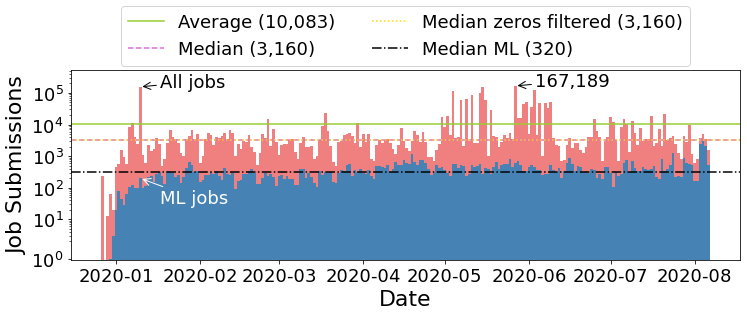

In [22]:
fig, ax = plt.subplots(figsize=(12,3.5))
plt.yscale("symlog", subsy = [1,2,3,4,5,6,7,8,9])
plt.ylim(bottom=1)
plt.ylim(top=5.5 * 10**5)
plt.locator_params(axis='y', numticks=12)
ax.bar(datelist, submissionlist.sum(axis=1), width=1, color="lightcoral")
ax.bar(datelist, submissionlist['ml'], width=1, color="steelblue")  # Plot ML jobs overlapping
plt.xlabel("Date", fontsize=22)
plt.ylabel("Job Submissions", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)

date_max_value = submissionlist.sum(axis=1).idxmax()
max_value = submissionlist.loc[date_max_value].sum()
ax.annotate("{:,}".format(int(max_value)),
            xy=(date_max_value, max_value), xycoords='data',
            xytext=(20, 0), textcoords='offset points',
            fontsize=18,
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc"
                           )
            )

annotate_date = submissionlist.sum(axis=1).sort_values().index[-3]
annotate_value_all_jobs = submissionlist.sum(axis=1).loc[annotate_date]
annotate_value_ml_jobs = submissionlist['ml'].loc[annotate_date]

ax.annotate("All jobs",
            xy=(annotate_date, annotate_value_all_jobs), xycoords='data',
            xytext=(20, 0), textcoords='offset points',
            fontsize=18,
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc"
                           )
            )

ax.annotate("ML jobs",
            xy=(annotate_date, annotate_value_ml_jobs), xycoords='data',
            xytext=(20, -25), textcoords='offset points',
            fontsize=18, color="white",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc",
                            color="white"
                           )
            )

combined = submissionlist.sum(axis=1)
median = combined.median()
median_zeroes_filtered = combined[combined > 0].median()
median_ml_jobs = submissionlist['ml'].median()
avg = combined.mean()
ax.axhline(avg, label="Average ({:,.0f})".format(avg), color="yellowgreen", linestyle="solid")
ax.axhline(median, label="Median ({:,})".format(int(median)), color="orchid", linestyle="dashed")
ax.axhline(median_zeroes_filtered, label="Median zeros filtered ({:,})".format(int(median_zeroes_filtered)), color="gold", linestyle="dotted")
ax.axhline(median_ml_jobs, label="Median ML ({:,})".format(int(median_ml_jobs)), color="black", linestyle="dashdot")
ax.legend(ncol=2, prop={"size": 18}, bbox_to_anchor=(0.5, 1.38), loc=9)

# fig.tight_layout()
date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"job_submission_count_{date_time}.pdf", bbox_inches='tight')